### Library Imports 

In [944]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 90)


### Data Loading

In [900]:
df = pd.read_csv('credit_messy.csv')


In [901]:
df.columns

Index(['ID', 'CreditLimit', 'Gender', 'Education', 'MaritalStatus', 'Age',
       'RepayStatApr', 'RepayStatMay', 'RepayStatJun', 'RepayStatJul',
       'RepayStatAug', 'RepayStatSep', 'BillSep', 'BillAug', 'BillJul',
       'BillJun', 'BillMay', 'BillApr', 'PaymentSep', 'PaymentAug',
       'PaymentJul', 'PaymentJun', 'PaymentMay', 'PaymentApr', 'Default'],
      dtype='object')

In [902]:
df.head()

,ID,CreditLimit,Gender,Education,MaritalStatus,Age,RepayStatApr,RepayStatMay,RepayStatJun,RepayStatJul,RepayStatAug,RepayStatSep,BillSep,BillAug,BillJul,BillJun,BillMay,BillApr,PaymentSep,PaymentAug,PaymentJul,PaymentJun,PaymentMay,PaymentApr,Default
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Initial data exploration 

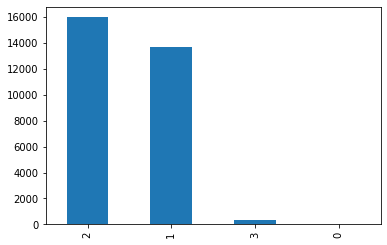

In [903]:
df.MaritalStatus.value_counts().plot(kind='bar')

In [904]:
df.MaritalStatus.value_counts()

2    15964
1    13659
3      323
0       54
Name: MaritalStatus, dtype: int64

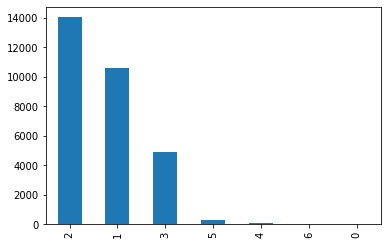

In [905]:
df.Education.value_counts().plot(kind='bar')

In [906]:
df.Education.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: Education, dtype: int64

In [907]:
# Either mislabelled or incorrect data (marriage = 0, Education = 0)
# Given this is such a small proportion of our set, i've decided to drop the rows containing this information

to_drop = (df.loc[(df.Education > 4 )|(df.Education == 0) ]).index
to_drop_again = (full_df.loc[full_df.MaritalStatus == 0]).index
df = df.drop(to_drop)
df = df.drop(to_drop_again)

In [908]:
df.columns =['ID','CreditLimit','Gender','Education','MaritalStatus','Age',
        'RepayStatApr','RepayStatMay','RepayStatJun','RepayStatJul','RepayStatAug','RepayStatSep',
        'BillApr','BillMay','BillJun','BillJul','BillAug','BillSep',
        'PrevPaymentApr','PrevPaymentMay','PrevPaymentJun','PrevPaymentJul','PrevPaymentAug','PrevPaymentSep',
        'Default']



### Getting a feel for the distribution of the data to analyse points for feature engineering

The following cell will help us interpret our EDA by mapping the categorical variables based on the columns values

In [909]:
gender_dict ={1:'male', 2:'female'}
education_dict = {1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others'}
marriage_dict = {1 : 'married', 2 : 'single', 3 : 'others'}
df['Gender'] = df['Gender'].map(gender_dict)
df['Education'] = df['Education'].map(education_dict)
df['MaritalStatus'] = df['MaritalStatus'].map(marriage_dict)

In [910]:
df['CreditLimit'].describe() # Credit limit exploration, mean limit of 167,000 NT$.

count      29601.000000
mean      167550.544914
std       129944.020953
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: CreditLimit, dtype: float64

Converting .describe into USD for interpretation

In [911]:
for result in df['CreditLimit'].describe():
    print('$' + str(round(result*0.033, 2)))

$976.83
$5529.17
$4288.15
$330.0
$1650.0
$4620.0
$7920.0
$33000.0


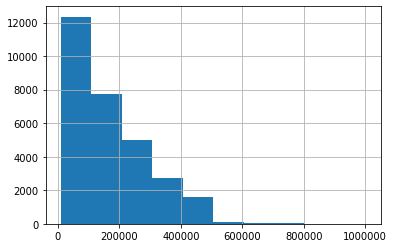

In [912]:
df.CreditLimit.hist()

In [913]:
total_default_pcnt = df['Default'].sum()/len(df.Default)
print('Average chance of default: ' + str(total_default_pcnt * 100) + '%')

Average chance of default: 22.31343535691362%


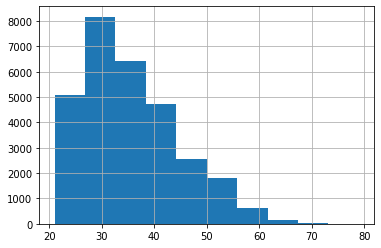

In [914]:
df.Age.hist()

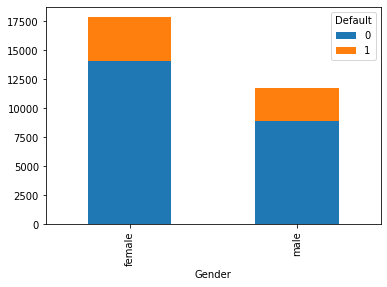

In [915]:
gender_df = pd.DataFrame(df.groupby(['Gender', 'Default']).size().unstack())
gender_df.plot(kind='bar', stacked = True)


In [916]:
gender_df['percentage_defaulted'] = round((gender_df[1]/(gender_df[0] + gender_df[1]))*100, 3)
gender_df

Default,0,1,percentage_defaulted
Gender,,,
female,14111,3744,20.969
male,8885,2861,24.357


In [917]:
education_df = pd.DataFrame(df.groupby(['Education', 'Default']).size().unstack())
                            
education_df

Default,0,1
Education,,
graduate school,8545,2036
high school,3640,1233
others,116,7
university,10695,3329


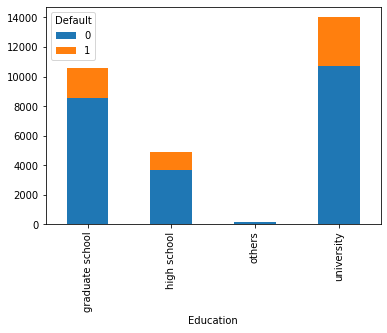

In [918]:
education_df = pd.DataFrame(df.groupby(['Education', 'Default']).size().unstack())
education_df.plot(kind='bar', stacked = True)

In [919]:
education_df['percentage_defaulted'] = round((education_df[1]/(education_df[0] + education_df[1]))*100, 3)
education_df

Default,0,1,percentage_defaulted
Education,,,
graduate school,8545,2036,19.242
high school,3640,1233,25.303
others,116,7,5.691
university,10695,3329,23.738


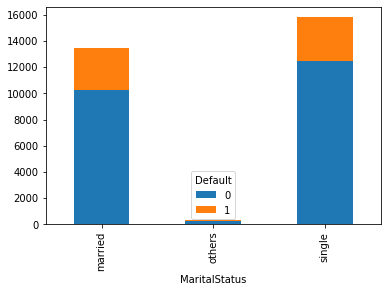

In [920]:
marriage_df = pd.DataFrame(df.groupby(['MaritalStatus', 'Default']).size().unstack())
marriage_df.plot(kind='bar', stacked = True)

In [921]:
marriage_df['percentage_defaulted'] = round((marriage_df[1]/(marriage_df[0] + marriage_df[1]))*100, 3)
marriage_df

Default,0,1,percentage_defaulted
MaritalStatus,,,
married,10285,3192,23.685
others,234,84,26.415
single,12477,3329,21.062


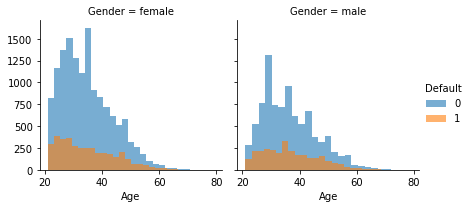

In [922]:
g = sns.FacetGrid(df, col='Gender', hue='Default')
g.map(plt.hist, 'Age', alpha=0.6, bins=25) #alpha is for opacity
g.add_legend()

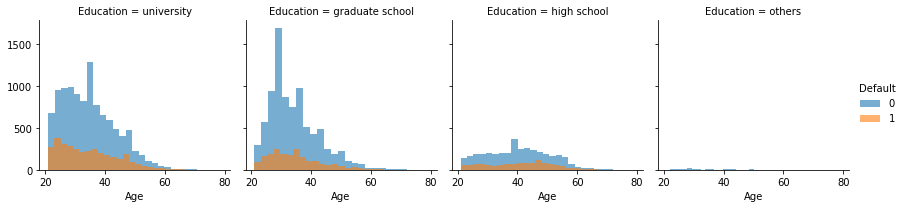

In [923]:
e = sns.FacetGrid(df, col='Education', hue='Default')
e.map(plt.hist, 'Age', alpha=0.6, bins=25) #alpha is for opacity
e.add_legend()

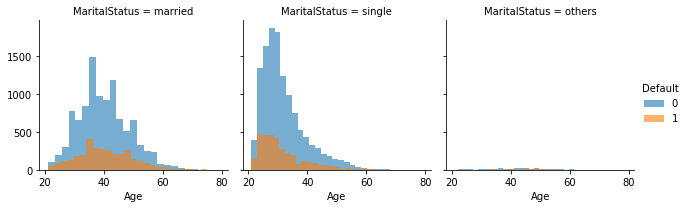

In [924]:
m = sns.FacetGrid(df, col='MaritalStatus', hue='Default')
m.map(plt.hist, 'Age', alpha=0.6, bins=25) #alpha is for opacity
m.add_legend()

In [925]:
df['average_bill'] =  (df['BillApr'] + df['BillMay'] + df['BillJun'] + df['BillJul'] + df['BillAug'] + df['BillSep'])/6
                                                                                        
df['average_payment'] = (df['PrevPaymentSep']  + df['PrevPaymentAug'] + df['PrevPaymentJul'] + df['PrevPaymentJun'] + df['PrevPaymentMay'] + df['PrevPaymentApr'])/6

df['total_payment'] = (df['PrevPaymentSep'] + df['PrevPaymentAug'] + df['PrevPaymentJul'] + df['PrevPaymentJun'] + df['PrevPaymentMay'] + df['PrevPaymentApr'])
                                                                                        
df['average_percentage_of_bill_paid'] = (df['average_payment']/df['average_bill'])*100
df['bill_paid/credit_limit'] = (df['total_payment']/df['CreditLimit'])*100
df['average_bill_paid/credit_limit'] = (df['average_payment']/df['CreditLimit'])*100

In [926]:
# From this step above we found 784 cases of users who had 0 total bill, and 0 payments.
# Given they were not using the cards, and there was a range of defaults and non defaults, we decided to remove this data as we were unsure on how someone
# who didn't use the card could default.

In [927]:
drop_non_users =( df.loc[(df.average_bill == 0) & (df.total_payment == 0)]).index
df = df.drop(drop_non_users)

In [928]:
df.head()

,ID,CreditLimit,Gender,Education,MaritalStatus,Age,RepayStatApr,RepayStatMay,RepayStatJun,RepayStatJul,RepayStatAug,RepayStatSep,BillApr,BillMay,BillJun,BillJul,BillAug,BillSep,PrevPaymentApr,PrevPaymentMay,PrevPaymentJun,PrevPaymentJul,PrevPaymentAug,PrevPaymentSep,Default,average_bill,average_payment,total_payment,average_percentage_of_bill_paid,bill_paid/credit_limit,average_bill_paid/credit_limit
0,1,20000,female,university,married,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1284.000000,114.833333,689,8.943406,3.445000,0.574167
1,2,120000,female,university,single,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,2846.166667,833.333333,5000,29.279147,4.166667,0.694444
2,3,90000,female,university,single,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,16942.166667,1836.333333,11018,10.838834,12.242222,2.040370
3,4,50000,female,university,married,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,38555.666667,1398.000000,8388,3.625926,16.776000,2.796000
4,5,50000,male,university,married,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,18223.166667,9841.500000,59049,54.005433,118.098000,19.683000


In [929]:
df['average_bill_paid/credit_limit'].value_counts()

0.000000     625
3.333333      77
1.666667      55
2.500000      50
3.500000      40
            ... 
15.242000      1
4.082292       1
0.158333       1
2.252400       1
0.722101       1
Name: average_bill_paid/credit_limit, Length: 23638, dtype: int64

In [930]:
# Getting Dummies for Categorical Variables
df = pd.get_dummies(df)

In [931]:
df_test = df.loc[df.average_percentage_of_bill_paid == np.inf].index
df = df.drop(df_test)

In [972]:
df

,ID,CreditLimit,Age,RepayStatApr,RepayStatMay,RepayStatJun,RepayStatJul,RepayStatAug,RepayStatSep,BillApr,BillMay,BillJun,BillJul,BillAug,BillSep,PrevPaymentApr,PrevPaymentMay,PrevPaymentJun,PrevPaymentJul,PrevPaymentAug,PrevPaymentSep,Default,average_bill,average_payment,total_payment,average_percentage_of_bill_paid,bill_paid/credit_limit,average_bill_paid/credit_limit,Gender_female,Gender_male,Education_graduate school,Education_high school,Education_others,Education_university,MaritalStatus_married,MaritalStatus_others,MaritalStatus_single
0,1,20000,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1284.000000,114.833333,689,8.943406,3.445000,0.574167,1,0,0,0,0,1,1,0,0
1,2,120000,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,2846.166667,833.333333,5000,29.279147,4.166667,0.694444,1,0,0,0,0,1,0,0,1
2,3,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,16942.166667,1836.333333,11018,10.838834,12.242222,2.040370,1,0,0,0,0,1,0,0,1
3,4,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,38555.666667,1398.000000,8388,3.625926,16.776000,2.796000,1,0,0,0,0,1,1,0,0
4,5,50000,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,18223.166667,9841.500000,59049,54.005433,118.098000,19.683000,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0,120891.500000,7091.666667,42550,5.866142,19.340909,3.223485,0,1,0,1,0,0,1,0,0
29996,29997,150000,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0,3530.333333,2415.000000,14490,68.407138,9.660000,1.610000,0,1,0,1,0,0,0,0,1
29997,29998,30000,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1,11749.333333,5216.666667,31300,44.399682,104.333333,17.388889,0,1,0,0,0,1,0,0,1
29998,29999,80000,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1,44435.166667,24530.166667,147181,55.204399,183.976250,30.662708,0,1,0,1,0,0,1,0,0


In [934]:
X = df[['Gender_female' ,'Gender_male' ,'Education_graduate school' ,'Education_high school', 'Education_others', 'Education_university','MaritalStatus_married', 'MaritalStatus_others',
       'MaritalStatus_single']]
# y = df['Default']

In [935]:
poly = PolynomialFeatures(degree =  3, interaction_only=True)

In [936]:
X2 = poly.fit_transform(X)
x3 = pd.DataFrame(X2)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28737,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [945]:
features = pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names(X.columns))


1                                                                  28742.0
Gender_female                                                      17306.0
Gender_male                                                        11436.0
Education_graduate school                                          10154.0
Education_high school                                               4742.0
                                                                    ...   
Education_others MaritalStatus_others MaritalStatus_single             0.0
Education_university MaritalStatus_married MaritalStatus_others        0.0
Education_university MaritalStatus_married MaritalStatus_single        0.0
Education_university MaritalStatus_others MaritalStatus_single         0.0
MaritalStatus_married MaritalStatus_others MaritalStatus_single        0.0
Length: 130, dtype: float64

In [965]:
list_of_cols = []
for col in features:
    list_of_cols.append(col)
    
for col in list_of_cols:
    if features[col].sum() == 0:
        features = features.drop(columns = (col))
    else:
        pass

In [987]:
to_drop = features[['Gender_female', 'Gender_male', 'Education_graduate school',
       'Education_high school', 'Education_others', 'Education_university',
       'MaritalStatus_married', 'MaritalStatus_others',
       'MaritalStatus_single']]

In [989]:
features = features.drop(to_drop, axis = 1)

In [992]:
features

,1,Gender_female Education_graduate school,Gender_female Education_high school,Gender_female Education_others,Gender_female Education_university,Gender_female MaritalStatus_married,Gender_female MaritalStatus_others,Gender_female MaritalStatus_single,Gender_male Education_graduate school,Gender_male Education_high school,Gender_male Education_others,Gender_male Education_university,Gender_male MaritalStatus_married,Gender_male MaritalStatus_others,Gender_male MaritalStatus_single,Education_graduate school MaritalStatus_married,Education_graduate school MaritalStatus_others,Education_graduate school MaritalStatus_single,Education_high school MaritalStatus_married,Education_high school MaritalStatus_others,Education_high school MaritalStatus_single,Education_others MaritalStatus_married,Education_others MaritalStatus_others,Education_others MaritalStatus_single,Education_university MaritalStatus_married,Education_university MaritalStatus_others,Education_university MaritalStatus_single,Gender_female Education_graduate school MaritalStatus_married,Gender_female Education_graduate school MaritalStatus_others,Gender_female Education_graduate school MaritalStatus_single,Gender_female Education_high school MaritalStatus_married,Gender_female Education_high school MaritalStatus_others,Gender_female Education_high school MaritalStatus_single,Gender_female Education_others MaritalStatus_married,Gender_female Education_others MaritalStatus_others,Gender_female Education_others MaritalStatus_single,Gender_female Education_university MaritalStatus_married,Gender_female Education_university MaritalStatus_others,Gender_female Education_university MaritalStatus_single,Gender_male Education_graduate school MaritalStatus_married,Gender_male Education_graduate school MaritalStatus_others,Gender_male Education_graduate school MaritalStatus_single,Gender_male Education_high school MaritalStatus_married,Gender_male Education_high school MaritalStatus_others,Gender_male Education_high school MaritalStatus_single,Gender_male Education_others MaritalStatus_married,Gender_male Education_others MaritalStatus_others,Gender_male Education_others MaritalStatus_single,Gender_male Education_university MaritalStatus_married,Gender_male Education_university MaritalStatus_others,Gender_male Education_university MaritalStatus_single
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28737,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28738,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
287

In [996]:
df.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            29990, 29991, 29992, 29993, 29994, 29995, 29996, 29997, 29998,
            29999],
           dtype='int64', length=28742)

In [617]:
# Here I decided to change the negative status of repayment each month to 0 if no interest is paid, keeping the lags the same from then 
# on out.

fil = (df.RepayStatApr == -2) | (df.PAY_1 == -1) | (df.PAY_1 == 0)
df.loc[fil, 'PAY_1'] = 0
fil = (df.RepayStatMay == -2) | (df.PAY_2 == -1) | (df.PAY_2 == 0)
df.loc[fil, 'PAY_2'] = 0
fil = (df.RepayStatJun == -2) | (df.PAY_3 == -1) | (df.PAY_3 == 0)
df.loc[fil, 'PAY_3'] = 0
fil = (df.RepayStatJul == -2) | (df.PAY_4 == -1) | (df.PAY_4 == 0)
df.loc[fil, 'PAY_4'] = 0
fil = (df.RepayStatAug == -2) | (df.PAY_5 == -1) | (df.PAY_5 == 0)
df.loc[fil, 'PAY_5'] = 0
fil = (df.RepayStatSep == -2) | (df.PAY_6 == -1) | (df.PAY_6 == 0)
df.loc[fil, 'PAY_6'] = 0
late = df[['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
draw_histograms(late, late.columns, 2, 3, 10)

AttributeError: 'DataFrame' object has no attribute 'PAY_1'